# Feature Selection and Regression Modeling for Flight Price Prediction

## Importing Packages and Loading the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_regression, SelectPercentile

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv(r'Documents\Flight_Price.csv')

In [3]:
df_train = df[~df['Price'].isnull()]
df_test = df[df['Price'].isnull()]

In [4]:
X = df_train.drop('Price', axis = 1)
y = df_train['Price']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state = 42)

## Feature Selection using Mutual Info Regression
Mutual information for regression will tell us how dependent our target variable is on each feature. Once we get our feature dependencies, we can drop some feature using a filter on percentile.

In [6]:
mutual_info = mutual_info_regression(X_train, y_train)

In [7]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False)

Route_1              0.896630
Route_2              0.862084
Total_Stops          0.753394
Month                0.588189
Route_3              0.535343
Jet Airways          0.522207
Cochin_dest          0.503354
Delhi_source         0.501386
Duration_Min         0.469253
Kolkata_source       0.428629
Arrival_Hour         0.378902
Delhi_dest           0.372915
IndiGo               0.352707
Arrival_Min          0.322771
Dep_Hour             0.304853
Route_4              0.293886
Air India            0.270568
Multiple carriers    0.264667
Dep_Min              0.246698
Day                  0.193318
Mumbai_source        0.192174
SpiceJet             0.190884
Hyderabad_dest       0.190127
Vistara              0.129923
Chennai_source       0.127014
Kolkata_dest         0.123125
GoAir                0.043924
Route_5              0.008085
Year                 0.003521
Trujet               0.000000
dtype: float64

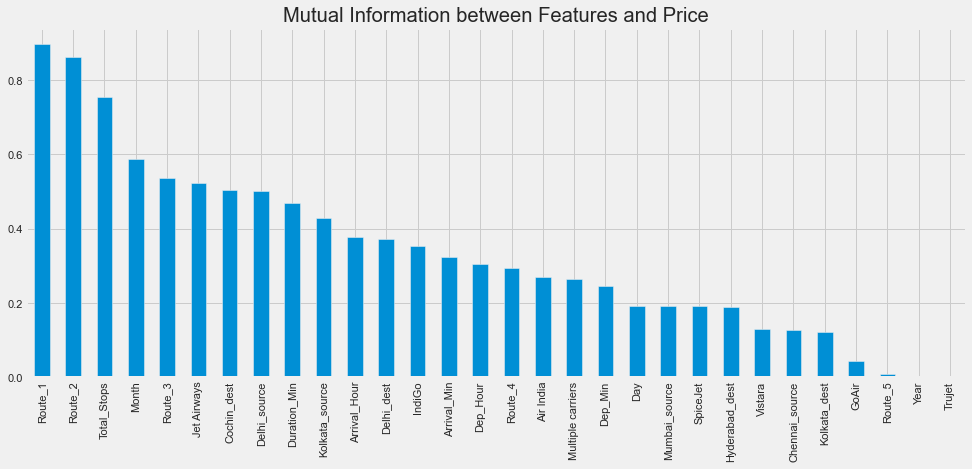

In [8]:
plt.style.use('fivethirtyeight')
mutual_info.sort_values(ascending=False).plot.bar(figsize=(15,6))
plt.title('Mutual Information between Features and Price')
plt.show()

Keeping the top 75 percentile of features to drop only features that have the lowest mutual information.

In [9]:
selected_columns = SelectPercentile(mutual_info_regression, percentile = 75)
selected_columns.fit(X_train, y_train)

SelectPercentile(percentile=75,
                 score_func=<function mutual_info_regression at 0x000001E9D0FB3B80>)

In [10]:
dropped_columns = [col for col in X.columns 
                   if col not in X.columns[selected_columns.get_support()]]

In [11]:
print('\033[1m' + 'Features to Drop')
for feature in dropped_columns:
    print('\033[0m' + feature)

Features to Drop
Year
GoAir
Trujet
Vistara
Route_5
Chennai_source
Mumbai_source
Kolkata_dest


In [12]:
X_train.drop(dropped_columns,axis=1,inplace=True)
X_test.drop(dropped_columns,axis=1,inplace=True)

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 100, num = 12)]
max_features = ['auto','sqrt']
max_depth = [int(x) for x in np.linspace(5,30,num=6)]
min_samples_split = [2,5,10,15,100]
min_samples_leaf = [1,2,5,10]

In [14]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [15]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', 
                               n_iter = 50, cv = 5, verbose=0, random_state=42, n_jobs = 1)

In [16]:
rf_random.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=50, n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 100, 100, 100,
                                                         100, 100, 100, 100,
                                                         100, 100, 100, 100]},
                   random_state=42, scoring='neg_mean_squared_error')

In [17]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10}

In [18]:
rf_random.best_score_

-4345392.293356856

In [19]:
rf_predictions = rf_random.predict(X_test)

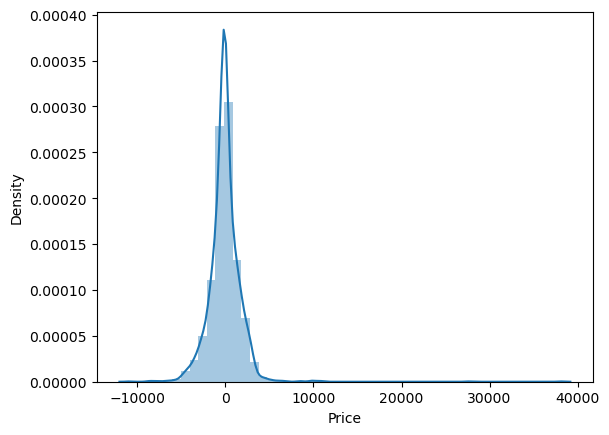

In [20]:
plt.rcParams.update(plt.rcParamsDefault)
sns.distplot(y_test-rf_predictions)
plt.show()

In [21]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

rf_mse = mean_squared_error(y_test,rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test,rf_predictions))
rf_r2 = r2_score(y_test,rf_predictions)

print('MSE:', mean_squared_error(y_test,rf_predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test,rf_predictions)))
print('R-squared:', r2_score(y_test,rf_predictions))

MSE: 3393887.5697004097
RMSE: 1842.250680472234
R-squared: 0.8401076349245127


## Gradient Boosting Regression

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

gb= GradientBoostingRegressor()

In [23]:
param_distributions = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": [0.05,0.1, 0.2,0.3,0.5,0.6],
}

In [24]:
gb_random = RandomizedSearchCV(estimator = gb, param_distributions=param_distributions, 
                               scoring='neg_mean_squared_error', n_iter = 100, cv = 5, 
                               verbose=0, random_state=42, n_jobs = 1)

In [25]:
gb_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=100,
                   n_jobs=1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2, 0.3,
                                                          0.5, 0.6],
                                        'max_leaf_nodes': [2, 5, 10, 20, 50,
                                                           100],
                                        'n_estimators': [1, 2, 5, 10, 20, 50,
                                                         100, 200, 500]},
                   random_state=42, scoring='neg_mean_squared_error')

In [26]:
gb_random.best_params_

{'n_estimators': 500, 'max_leaf_nodes': 5, 'learning_rate': 0.3}

In [27]:
gb_random.best_score_

-4608818.999542556

In [28]:
gb_predictions = gb_random.predict(X_test)

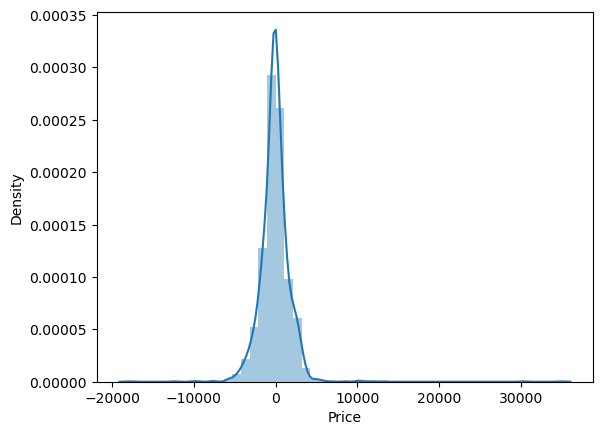

In [29]:
sns.distplot(y_test-gb_predictions)
plt.show()

In [30]:
gb_mse = mean_squared_error(y_test,gb_predictions)
gb_rmse = np.sqrt(mean_squared_error(y_test,gb_predictions))
gb_r2 = r2_score(y_test,gb_predictions)

print('MSE:', mean_squared_error(y_test,gb_predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test,gb_predictions)))
print('R-squared:', r2_score(y_test,gb_predictions))

MSE: 3555799.3065922586
RMSE: 1885.68271631053
R-squared: 0.8324796714126268


## XGBoost Regression

In [31]:
import xgboost as xg

In [32]:
xg = xg.XGBRegressor()

In [33]:
n_estimators = [100]
learning_rate = ['0.05','0.1', '0.2','0.3','0.5','0.6']
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
subsample=[0.7,0.6,0.8]
min_child_weight=[3,4,5,6,7]

In [34]:
random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
              'min_child_weight': min_child_weight}

In [35]:
xg_random = RandomizedSearchCV(estimator = xg, param_distributions = random_grid,
                               scoring='neg_mean_squared_error', n_iter = 100, cv = 5, 
                               verbose=0, random_state=42, n_jobs = 1)

In [36]:
xg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                          n_estimators=100, n_jobs=None,
                                 

In [37]:
xg_random.best_params_

{'subsample': 0.7,
 'n_estimators': 100,
 'min_child_weight': 4,
 'max_depth': 10,
 'learning_rate': '0.05'}

In [38]:
xg_random.best_score_

-3888378.5278758095

In [39]:
xg_predictions = xg_random.predict(X_test)

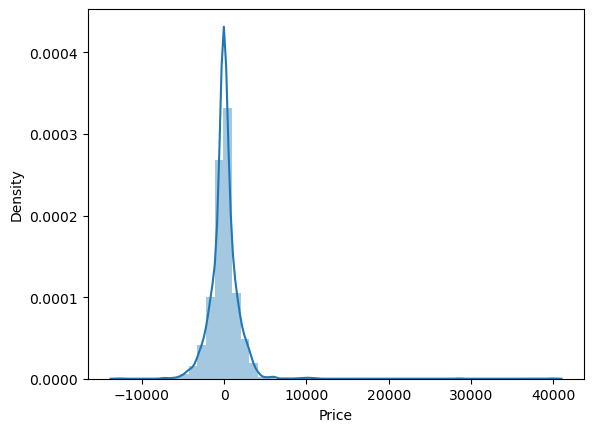

In [40]:
sns.distplot(y_test-xg_predictions)
plt.show()

In [41]:
xg_mse = mean_squared_error(y_test,xg_predictions)
xg_rmse = np.sqrt(mean_squared_error(y_test,xg_predictions))
xg_r2 = r2_score(y_test,xg_predictions)

print('MSE:', mean_squared_error(y_test,xg_predictions))
print('RMSE:', np.sqrt(mean_squared_error(y_test,xg_predictions)))
print('R-squared:', r2_score(y_test,xg_predictions))

MSE: 3238355.2132447693
RMSE: 1799.5430567910203
R-squared: 0.8474350539414165


## Comparing and Evaluating Results

In [42]:
results_dictionary = {'Model': ['Random Forest','Gradient Boost', 'XGBoost'],
          'MSE': [round(rf_mse), round(gb_mse), round(xg_mse)],
          'RMSE': [rf_rmse, gb_rmse, xg_rmse], 
          'R^2': [rf_r2, gb_r2, xg_r2]}

results_df = pd.DataFrame(results_dictionary)
results_df

,Model,MSE,RMSE,R^2
0,Random Forest,3393888,1842.250680,0.840108
1,Gradient Boost,3555799,1885.682716,0.832480
2,XGBoost,3238355,1799.543057,0.847435


**Thoughts**

The XGBoost regressor slightly edged out the Random Forest and Gradient Boost model in error metrics and R squared. I had been expecting a greater improvement for the error metrics with the XGBoost Regressor over the Gradient Boost considering that the model iterates on each successive tree in an effort to minimize the residual value, but nonetheless it still returned the best error metrics of the 3 models.

## Evaluating our XGBoost Predictions

### Visualizing Feature Importance

In [43]:
xg_coef = xg_random.best_estimator_.feature_importances_

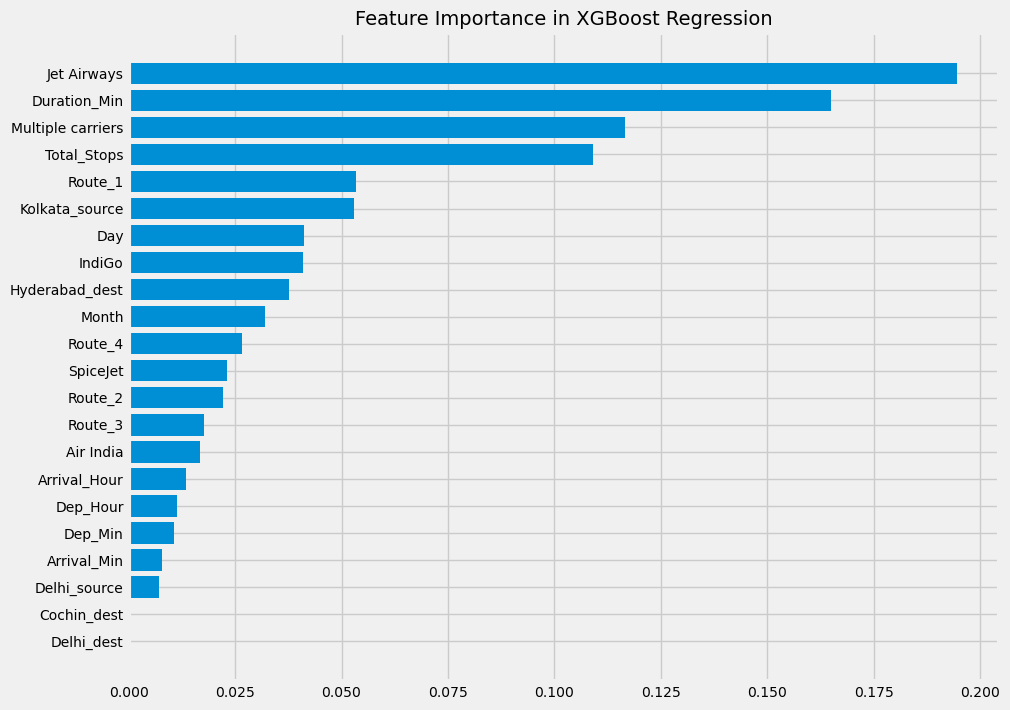

In [44]:
sorted_idx = xg_coef.argsort()

plt.style.use('fivethirtyeight')
fig = plt.figure(figsize=(10,8))
plt.barh(X_train.columns[sorted_idx], xg_coef[sorted_idx])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title('Feature Importance in XGBoost Regression', fontsize=14)
plt.show()

**Thoughts**

Whether or not the flight was with Jet Airways being the most important feature is very telling in showing us that Jet Airways contributes significantly in gaining information on the price of the ticket. Most of the other airlines are considered low-cost carriers, which may also contribute to the high importance placed on Jet Airways in determining price. Despite our feature selection process to drop features that had low dependency with the target variable, we still ended up with 3 features that registered no information gain in our XGBoost model.

### Combining Predictions with the Test Set

In [45]:
X = X_test.join(y_test)

In [46]:
X['XG_predictions'] = xg_predictions

In [47]:
X['Difference'] = X['XG_predictions'] - X['Price']
X.head()

,Total_Stops,Day,Month,Arrival_Hour,Arrival_Min,Dep_Hour,Dep_Min,Duration_Min,Air India,IndiGo,Jet Airways,Multiple carriers,SpiceJet,Route_1,Route_2,Route_3,Route_4,Delhi_source,Kolkata_source,Cochin_dest,Delhi_dest,Hyderabad_dest,Price,XG_predictions,Difference
4830,1,24,3,19,50,15,10,280,0,1,0,0,0,2,20,3,12,0,1,0,0,0,7476.0,5829.272949,-1646.727051
3771,1,1,4,18,50,7,10,700,0,0,0,0,0,2,14,3,12,0,1,0,0,0,7927.0,8367.757812,440.757812
1523,1,27,3,19,45,19,15,1470,0,0,1,0,0,3,7,6,12,1,0,1,0,0,5963.0,10552.399414,4589.399414
3393,1,21,5,19,0,8,0,660,0,0,1,0,0,3,7,6,12,1,0,1,0,0,16289.0,14409.949219,-1879.050781
4169,0,12,6,10,10,7,10,180,0,0,1,0,0,0,13,24,12,0,0,0,1,0,8016.0,6600.792480,-1415.207520


### Re-adding the Categorical Variables to the Test Set
This will make for easier visualizations

In [48]:
X_cat = pd.read_csv(r'Documents\Flight_Categories.csv')

In [49]:
X_test_cat = pd.merge(X, X_cat, left_index=True, right_index=True, how='left')

In [50]:
X_test_cat.head(1)

,Total_Stops_x,Day,Month,Arrival_Hour,Arrival_Min,Dep_Hour,Dep_Min,Duration_Min,Air India,IndiGo,Jet Airways,Multiple carriers,SpiceJet,Route_1,Route_2,Route_3,Route_4,Delhi_source,Kolkata_source,Cochin_dest,Delhi_dest,Hyderabad_dest,Price,XG_predictions,Difference,Airline,Source,Destination,Route,Total_Stops_y
4830,1,24,3,19,50,15,10,280,0,1,0,0,0,2,20,3,12,0,1,0,0,0,7476.0,5829.272949,-1646.727051,IndiGo,Kolkata,Banglore,CCU → HYD → BLR,1 stop


### Visualizing RMSE by Airline

In [51]:
# Creating a function that calculates the RMSE that can be applied to a grouped dataframe
def rmse(df):
    return np.sqrt(mean_squared_error(df['Price'], df['XG_predictions']))

In [52]:
airline_rmse = X_test_cat.groupby('Airline').apply(rmse).reset_index().rename(columns={0:'RMSE'}).sort_values('RMSE')
airline_predict = X_test_cat.groupby('Airline')['XG_predictions'].mean().round().reset_index().rename(columns={'XG_predictions': 'Predicted Price'}).sort_values('Predicted Price')
airline_predict['Predicted Price'] = airline_predict['Predicted Price'].astype(int)

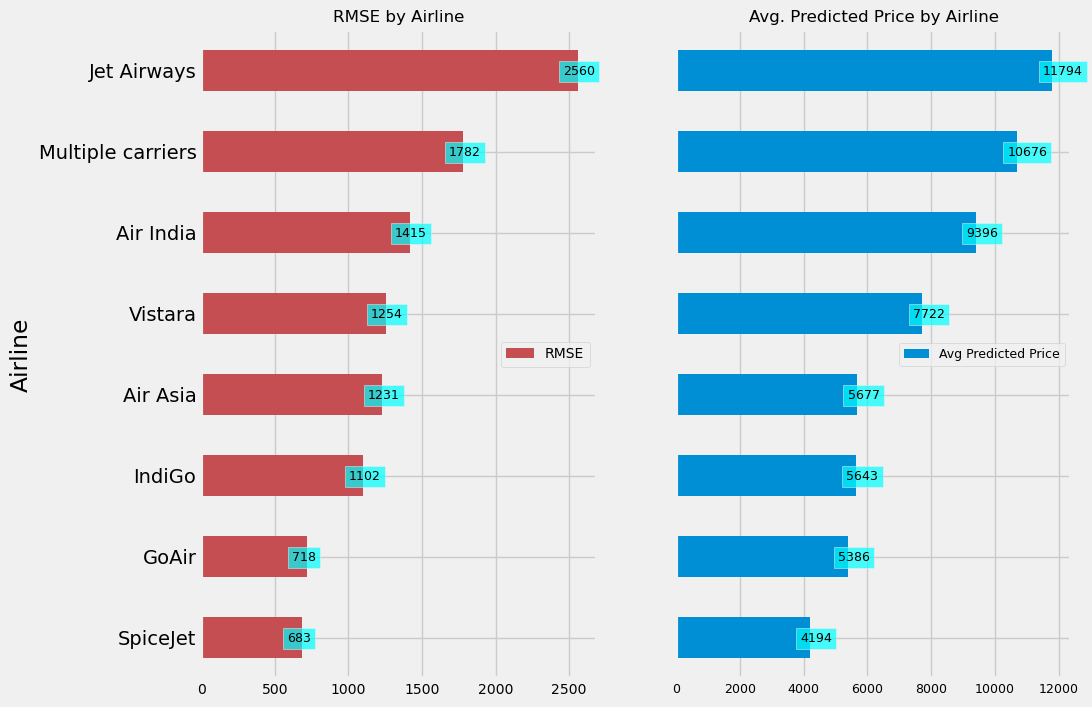

In [53]:
plt.style.use('fivethirtyeight')

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, figsize=(10, 8)
)
airline_rmse.plot.barh(x = 'Airline', y = 'RMSE', color = 'r', ax=ax1, legend = False)
for i, v in enumerate(airline_rmse['RMSE']):
    ax1.text(v-100, i-.05, str(round(v)), color = 'black', fontsize=9,
            Bbox = dict(facecolor = 'cyan', alpha =.7, pad = 3))
    
airline_predict.plot.barh(x = 'Airline', y = 'Predicted Price', ax=ax2, legend = False)
for i, v in enumerate(airline_predict['Predicted Price']):
    ax2.text(v-300, i-.05, str(v), color = 'black', fontsize=9,
            Bbox = dict(facecolor = 'cyan', alpha =.7, pad = 3))

plt.tick_params(axis='both', which='major', labelsize=9)
plt.setp(ax1.get_xticklabels(), Fontsize=10)

plt.rcParams['ytick.labelsize'] = 8
ax1.legend(['RMSE'], fontsize=10, loc = 'center right')
ax2.legend(['Avg Predicted Price'], fontsize = 9, loc = 'center right')
ax1.set_title('RMSE by Airline', fontsize = 12)
ax2.set_title('Avg. Predicted Price by Airline', fontsize = 12)
plt.show()

**Thoughts**

Jet Airways flight prices had the highest RMSE value of all airlines while also being the most expensive on average, as well as the most frequented airline. From the graphs above, we can clearly see that our RMSE increases as the average price of the airline increases. With the airline variables, we could very likely reduce our error if we knew which airlines made up the Multiple carriers category.

### Visualizing RMSE by # of Stops

In [54]:
# Grouping the dataframe by the # of stops and calculating the RMSE for each group
stops_rmse = X_test_cat.groupby('Total_Stops_x').apply(rmse).reset_index().rename(columns={'Total_Stops_x': 'Stops', 0:'RMSE'}).sort_values('Stops',ascending=False)
stops_predict = X_test_cat.groupby('Total_Stops_x')['XG_predictions'].mean().round().reset_index().rename(columns={'Total_Stops_x': 'Stops', 'XG_predictions': 'Predicted Price'}).sort_values('Stops',ascending=False)
stops_predict['Predicted Price'] = stops_predict['Predicted Price'].astype(int)

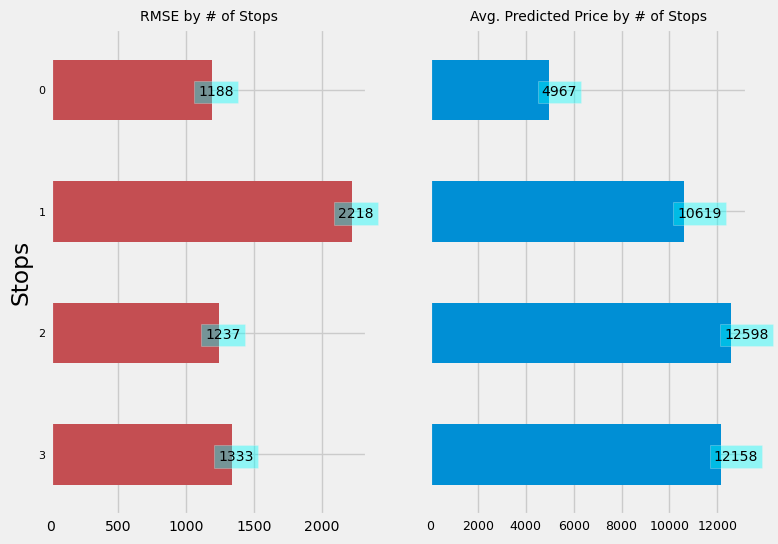

In [55]:
plt.style.use('fivethirtyeight')

fig, (ax1, ax2) = plt.subplots(
    1, 2, sharey=True, figsize=(8, 6))
stops_rmse.plot.barh(x = 'Stops', y = 'RMSE', color = 'r', ax=ax1, legend=False)
for i, v in enumerate(stops_rmse['RMSE']):
    ax1.text(v-100, i-.05, str(round(v)), color = 'black', fontsize=10,
            Bbox = dict(facecolor = 'cyan', alpha =.4, pad = 3))
    
stops_predict.plot.barh(x = 'Stops', y = 'Predicted Price', ax=ax2, legend=False)
for i, v in enumerate(stops_predict['Predicted Price']):
    ax2.text(v-300, i-.05, str(v), color = 'black', fontsize=10,
            Bbox = dict(facecolor = 'cyan', alpha =.4, pad = 3))

plt.tick_params(axis='both', which='major', labelsize=9)
plt.rcParams['ytick.labelsize'] = 8
plt.setp(ax1.get_xticklabels(), Fontsize=10)
ax1.set_title('RMSE by # of Stops', fontsize = 10)
ax2.set_title('Avg. Predicted Price by # of Stops', fontsize = 10)
plt.show()

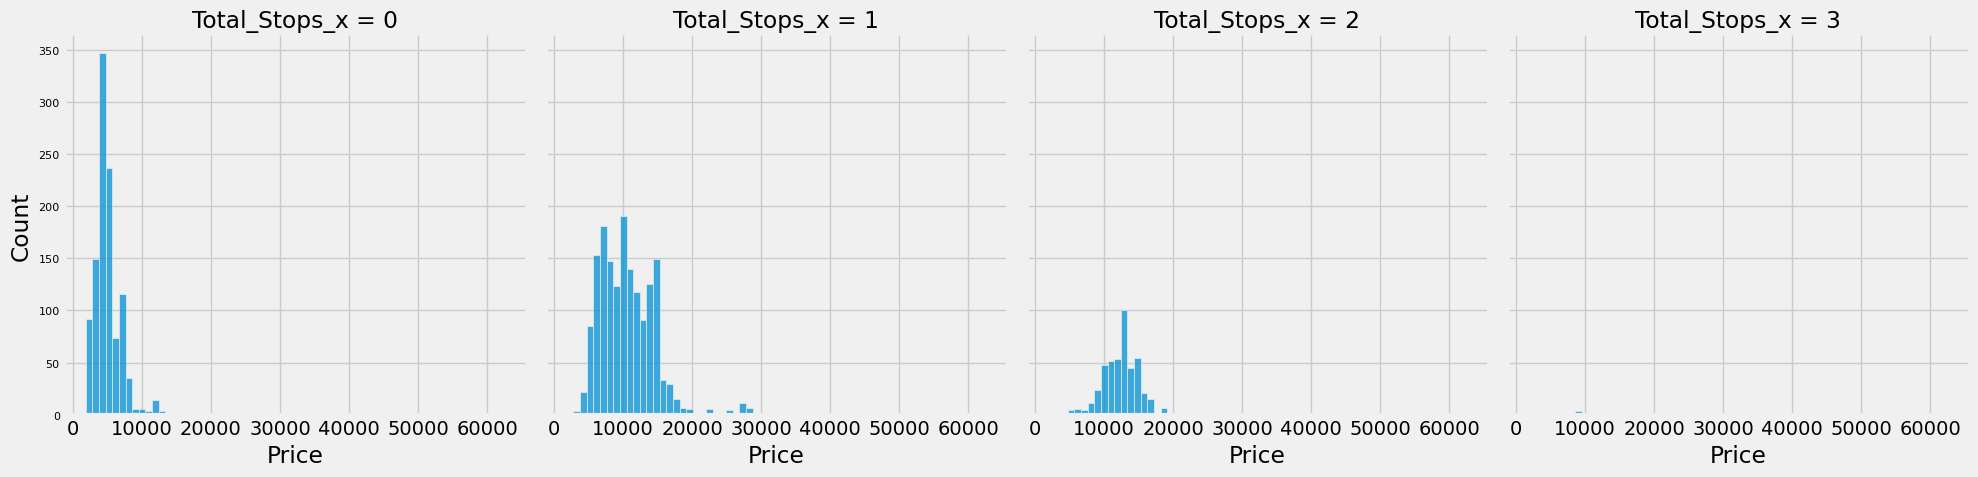

In [56]:
sns.displot(
    X_test_cat, x="Price", col="Total_Stops_x")
plt.show()

**Thoughts**

Our XG model was best at predicting 2 and 3 stop journeys, while it had the greatest error in predicted 1 stop journeys. If we dug into all 1 stop journeys in our test set, we might be able to pinpoint it on a few airlines or specific routes. Looking at the price distribution of 1 stop flights above, we can see a more visible skew in the data compared to the other groups due to some more expensive outliers.

### Visualizing RMSE by Departure Hour

In [57]:
# Grouping the dataframe by hour and calculating the RMSE for each hour
hour_rmse = X_test_cat.groupby('Dep_Hour').apply(rmse).reset_index().rename(columns={'Dep_Hour': 'Hour', 0:'RMSE'})
hour_rmse['Above Model RMSE'] = hour_rmse['RMSE'] > xg_rmse

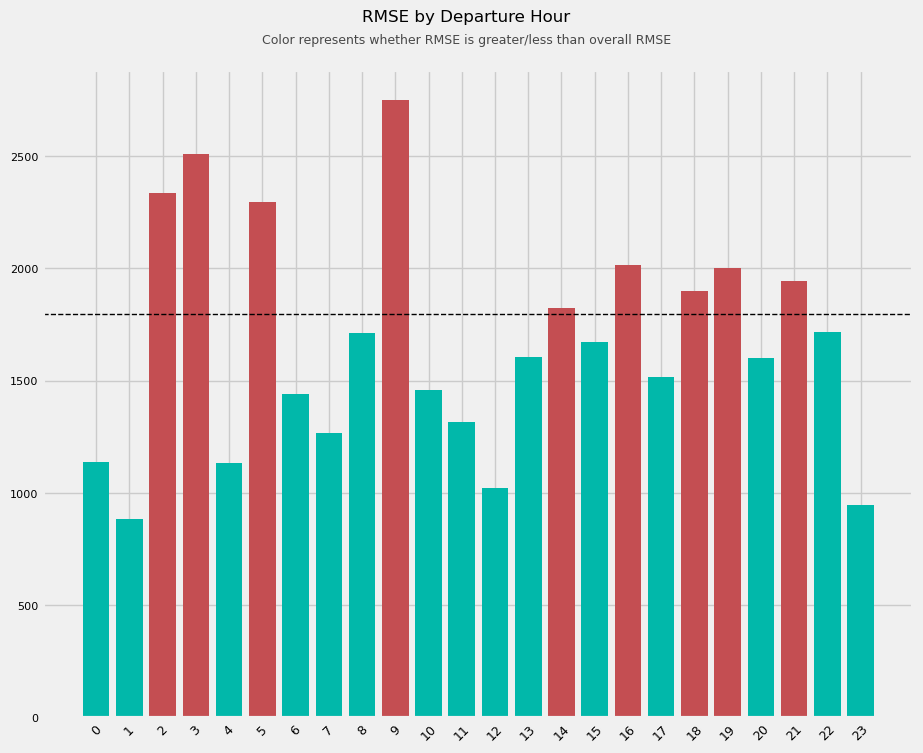

In [58]:
fig = plt.figure(figsize=(10,8))
colors = []
for hour in list(hour_rmse['Above Model RMSE']):
    if hour == True:
        colors.append('r')
    else:
        colors.append('#01b8aa')

plt.bar(hour_rmse['Hour'], hour_rmse['RMSE'], linewidth = 2, color = colors)
plt.axhline(y=xg_rmse, color='black', linestyle='--', linewidth = 1)
plt.xticks(hour_rmse.index, rotation=45, fontsize = 9)
plt.text(x= 8,y=3100,s='RMSE by Departure Hour', fontsize=12)
plt.text(x=5, y=3000, s ='Color represents whether RMSE is greater/less than overall RMSE', fontsize=9, alpha = 0.7)
plt.show()

In [59]:
# Creating a function to group the hours by time of day

def day_part(df):
    if df['Hour'] >=5 and df['Hour'] < 9:
        return 'Early Morning'
    elif df['Hour'] >= 9 and df['Hour'] < 12:
        return 'Late Morning'
    elif df['Hour'] >= 12 and df['Hour'] < 17:
        return 'Afternoon'
    elif df['Hour'] >= 17 and df['Hour'] < 21:
        return 'Evening'
    elif df['Hour'] >=21 or df['Hour'] < 5:
        return 'Late Night'

hour_rmse['day_part'] = hour_rmse.apply(day_part, axis = 1)

In [60]:
# Creating a df to calculate RMSE by time of day
day_part_rmse = hour_rmse.groupby('day_part')['RMSE'].mean().reset_index()
day_part_rmse['sort'] = [2,0,3,1,4]
day_part_rmse = day_part_rmse.sort_values('sort')

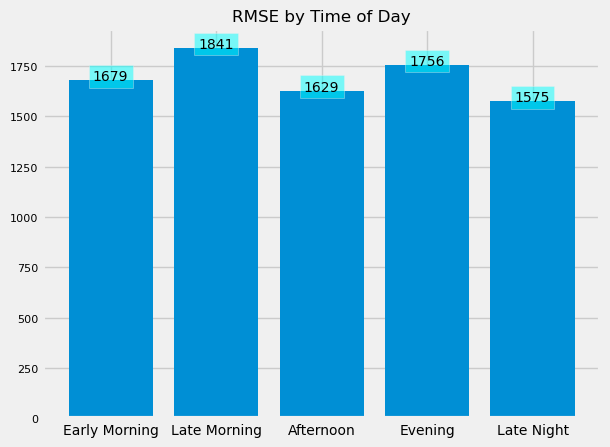

In [61]:
plt.bar(day_part_rmse['day_part'], day_part_rmse['RMSE'])

for i, v in enumerate(day_part_rmse['RMSE']):
    plt.text(i-.17, v, str(round(v)), color = 'black', fontsize=10,
            Bbox = dict(facecolor = 'cyan', alpha =.5, pad = 3))


plt.title('RMSE by Time of Day', fontsize=12)
plt.xticks(fontsize= 10)
plt.show()

**Thoughts**

Looking at the error by hour, it's hard to see any real pattern outside of a few hours in the late morning having the highest RMSE. When grouping by the general time of day, it's clear that there isn't much differentiation in error between times of departure.

## Potential Ways to Improve / Ideas for Additional Data

- Dimensionality Reduction techniques: Using PCA or LDA to try and reduce the dimensionality and sparsity of the data to capture most of the variance within a smaller subspace.
- Remove outliers: either price outliers, or duration outliers. If we remove flights that are unusually high or flights that are extremely long due to extended layovers, maybe we can see improved predictions.
- Add data on when the flight was booked: Most often, flights tend to be more expensive the closer to the departure date that they are booked, so we could be able to explain more of the variance in prices if we knew when the tickets were booked.
- Add data on where the flight was booked: Was the flight booked through the airline or 3rd party? People often search through 3rd party websites and services for cheaper tickets, so having info on how/where the flight was booked might be helpful.